#Submitted by: Gattadi Vivek (2019MCB1217)

##Importing the Libraries:

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas_datareader import data, wb
import pandas_datareader as pdr
import seaborn as sns
import datetime
import statsmodels.api as sm
from scipy.stats import kstest
import math
from numpy.linalg import norm
from scipy.stats import norm
sns.set()

In [ ]:
# start = datetime.datetime(1983, 03, 21)
# end = datetime.datetime(2022, 04, 22)
# fin_data = pandas_datareader.data.Datareader()

##Downloading the Data from Yahoo Finance:

In [ ]:
fin_data = pd.read_csv('AMD.csv')
fin_data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1980-03-17,0.0,3.302083,3.125000,3.145833,3.145833,219600
1,1980-03-18,0.0,3.125000,2.937500,3.031250,3.031250,727200
2,1980-03-19,0.0,3.083333,3.020833,3.041667,3.041667,295200
3,1980-03-20,0.0,3.062500,3.010417,3.010417,3.010417,159600
4,1980-03-21,0.0,3.020833,2.906250,2.916667,2.916667,130800


In [ ]:
fin_data.describe()

,Open,High,Low,Close,Adj Close,Volume
count,10617.000000,10617.000000,10617.000000,10617.000000,10617.000000,1.061700e+04
mean,14.877344,15.509155,14.845824,15.178343,15.178343,1.677031e+07
std,20.307494,20.517855,19.657735,20.091115,20.091115,2.625745e+07
min,0.000000,1.690000,1.610000,1.620000,1.620000,0.000000e+00
25%,4.812500,5.270000,5.020833,5.166667,5.166667,1.183800e+06
50%,9.500000,9.720000,9.281250,9.500000,9.500000,6.311800e+06
75%,15.540000,15.830000,15.250000,15.500000,15.500000,2.068630e+07
max,163.279999,164.460007,156.100006,161.910004,161.910004,3.250584e+08


In [ ]:
fin_data = fin_data.iloc[761:,:]
#fin_data.shape
fin_data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
1522,1986-03-25,15.0625,15.1250,14.8750,15.0625,15.0625,388200
1523,1986-03-26,15.0625,15.0625,14.7500,14.7500,14.7500,496200
1524,1986-03-27,14.8750,15.0000,14.3125,14.6250,14.6250,1245400
1525,1986-03-31,14.5000,14.5000,14.0625,14.2500,14.2500,831000
1526,1986-04-01,14.2500,14.3750,13.7500,13.7500,13.7500,818000


##Plot for Stock Price Data

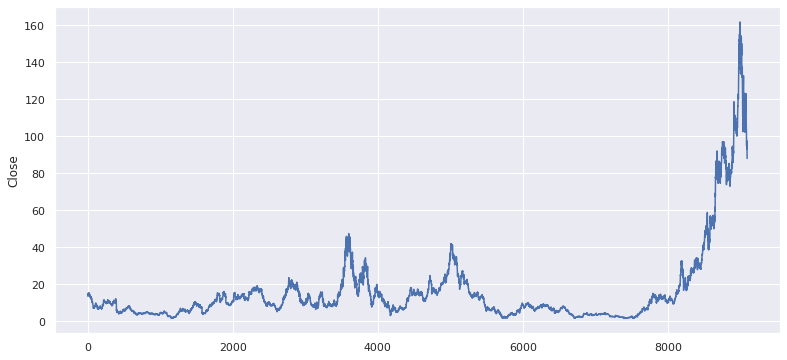

In [ ]:
plt.figure(figsize=(13, 6))
sns.lineplot(x=[i for i in range(len(fin_data))], y=fin_data['Close'])

##Log Returns

In [ ]:
fin_data['log'] = np.log(fin_data['Close']/fin_data['Open'])

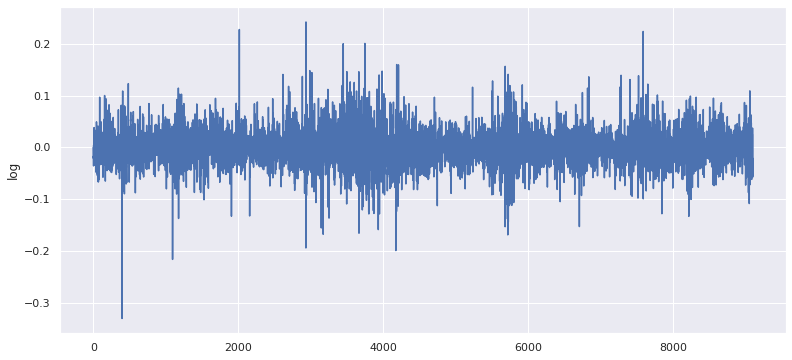

In [ ]:
plt.figure(figsize=(13, 6))
sns.lineplot(x=[i for i in range(len(fin_data))], y=fin_data['log'])

##QQ-Plot

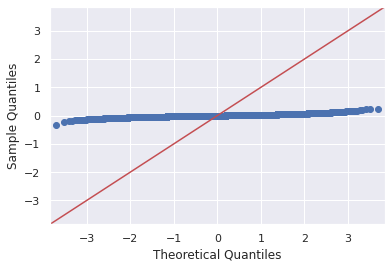

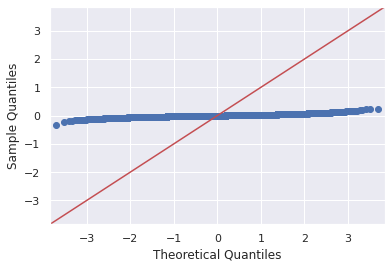

In [ ]:
sm.qqplot(fin_data['log'], line ='45')

##Normal Distribution Test

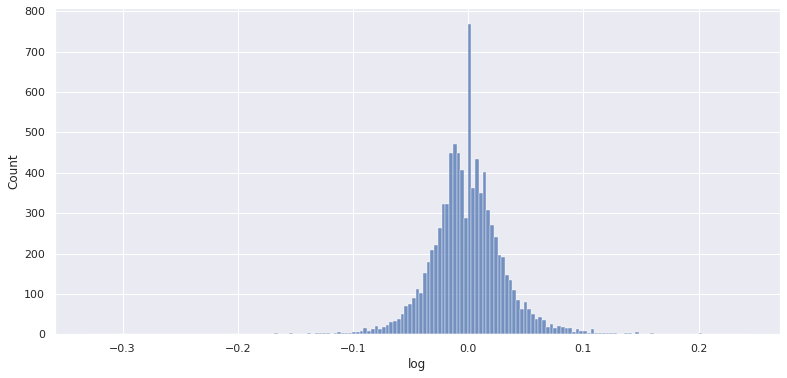

In [ ]:
plt.figure(figsize=(13, 6))
sns.histplot(fin_data['log'])

In [ ]:
x = kstest(fin_data['log'], "norm")  
print(x)

KstestResult(statistic=0.4569549546878884, pvalue=0.0)


Since the p value is less than 0.5, null hypothesis is rejected 

=>Data is not normally distributed.

##Volatity

In [ ]:
volatility = fin_data['log'].std()*252**0.5
volatility

0.511787775470724

Text(0.5, 1.0, 'AAPL volatility: 51.18000000000001%')

<Figure size 1080x504 with 0 Axes>

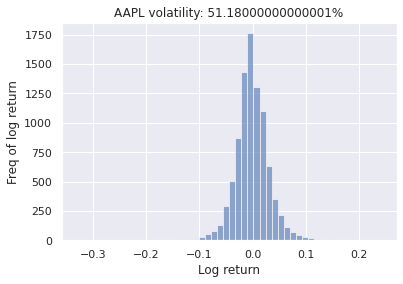

In [ ]:
str_vol = str(round(volatility, 4)*100)
plt.figure(figsize=(15, 7))
fig, ax = plt.subplots()
fin_data['log'].hist(ax=ax, bins=50, alpha=0.6, color='b')
ax.set_xlabel("Log return")
ax.set_ylabel("Freq of log return")
ax.set_title("AAPL volatility: " + str_vol + "%")

##6. Risk free rate for the given currency (3-Months treasury rate for the currency)

In practice, the risk-free rate is commonly considered to equal to the interest paid on a 3-month government Treasury bill

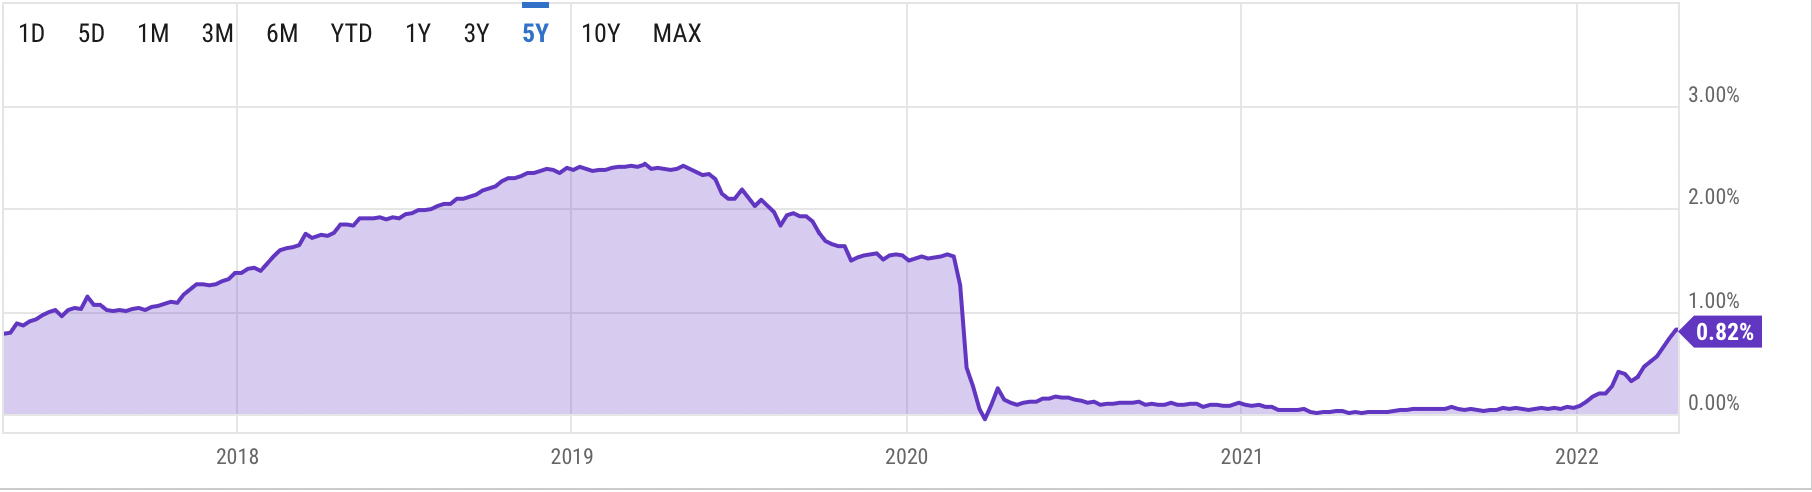

**Current Risk Free Interest Rate for month Treasury Bill is 0.82%**

##Option Price, CRR, Black-Scholes and Simulation Methods

##CRR Model

In [ ]:
def fetchData(fin_data):

    #fin_data = pdr.get_data_yahoo(ticker)
    data_AdjClose = fin_data["Adj Close"]
    data_diff = data_AdjClose.diff()
    data_ret = data_diff/data_AdjClose
    ret_pos =[]
    ret_neg =[]

    for dt in data_ret:
        if dt >0:
            ret_pos.append(dt)
        elif dt < 0:
            ret_neg.append(dt)
        else:
            pass

    u = np.average(ret_pos)
    d = np.average(ret_neg)
    data_close = data["Close"]
    s0 = data_close[-1]
    sigma = np.std(data_ret)

    return u, d, s0, sigma

In [ ]:
def nCr(n,r):
    f = math.factorial
    return f(n) / f(r) / f(n-r)

class OptionCRR():

    def __init__(self, s0, sigma, strike, maturity, rfr, n, dyield = None):

        self.s0 = s0
        self.sigma = sigma
        self.rfr = rfr
        self.maturity = maturity
        self.strike = strike
        self.n = n
        self.dyield = dyield

    def price(self):
        delta = float(self.maturity)/float(self.n)
        u = math.exp(self.sigma*math.sqrt(delta))
        d = 1/math.exp(self.sigma*math.sqrt(delta))
        if self.dyield == None:
            q = (math.exp(self.rfr*delta) - d) / (u - d)

        else:
            q = (math.exp((self.rfr-self.dyield)*delta) - d) / (u - d)

        prc = 0
        temp_stock = 0
        temp_payout = 0
        for x in range(0, self.n + 1):
            temp_stock = self.s0*((u)**(x))*((d)**(self.n - x))
            temp_payout = max(temp_stock - self.strike, 0)
            prc += nCr(self.n, x)*(q**(x))*((1-q)**(self.n - x))*temp_payout
        prc = prc / ((1+ self.rfr*delta )**self.n)
        #prc = prc / math.exp(self.rfr*delta)
        return prc

In [ ]:
df1 = fin_data['Adj Close']
log_price = np.log(df1)
log_ret = log_price.diff()
log_ret

1522          NaN
1523    -0.020965
1524    -0.008511
1525    -0.025975
1526    -0.035718
           ...   
10612    0.008879
10613    0.031865
10614   -0.030482
10615   -0.045366
10616   -0.019215
Name: Adj Close, Length: 9095, dtype: float64

In [ ]:
vol = log_ret.std()
vol

0.0384062822619612

In [ ]:
vol_annual = np.sqrt(252)*vol
vol_annual

0.6096808298862035

In [ ]:
s0 = fin_data['Close']
#s0 = s0[-1]
s0

1522     15.062500
1523     14.750000
1524     14.625000
1525     14.250000
1526     13.750000
           ...    
10612    93.889999
10613    96.930000
10614    94.019997
10615    89.849998
10616    88.139999
Name: Close, Length: 9095, dtype: float64

In [ ]:
rfr = 0.0082
call_price = []

for i in range(50,86,5):
    cr = OptionCRR(88.13, vol_annual, i, 37/365.0, rfr, 4)
    call_price.append(cr.price())

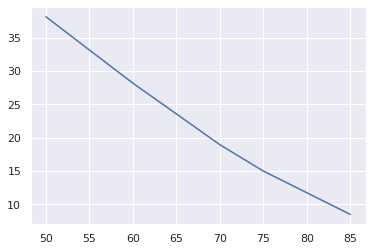

In [ ]:
sns.lineplot(x=[i for i in range(50,86,5)], y=call_price)

##Black Scholes Model

In [ ]:


S = 88.14 # stock price S_{0}
T = 37/365 # time to maturity
r = 0.0082 # risk free risk in annual %
q = 0.02 # annual dividend rate
sigma = 0.51 # annual volatility in %


In [ ]:
def black_scholes_call(S,K,T,r,q,sigma):

    d1 = (np.log(S/K) + (r - q + sigma**2/2)*T) / sigma*np.sqrt(T)
    d2 = d1 - sigma* np.sqrt(T)
    call = S * np.exp(-q*T)* norm.cdf(d1) - K * np.exp(-r*T)*norm.cdf(d2)
    return call

In [ ]:
call_price_bs = []

for i in range(50,86,5):
    bs_price = black_scholes_call(S,i,T,r,q,sigma)
    call_price_bs.append(bs_price)


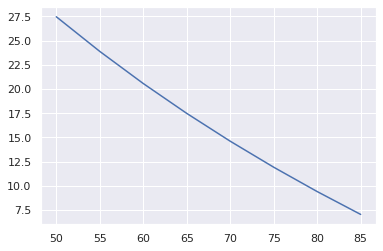

In [ ]:
sns.lineplot(x=[i for i in range(50,86,5)], y=call_price_bs)

#Simulation Model

In [ ]:
def GBM_paths(S, T, r, q, sigma, steps, N):

    # S(t) = S(0)*exp(mu-sigm**2/2)+ sigma*B(t) GBM.
    dt = T/steps
    ST = np.log(S) + np.cumsum(((r - q - sigma**2/2)*dt +\
    sigma*np.sqrt(dt) * \
    np.random.normal(size=(steps,N))),axis=0)
    return np.exp(ST)

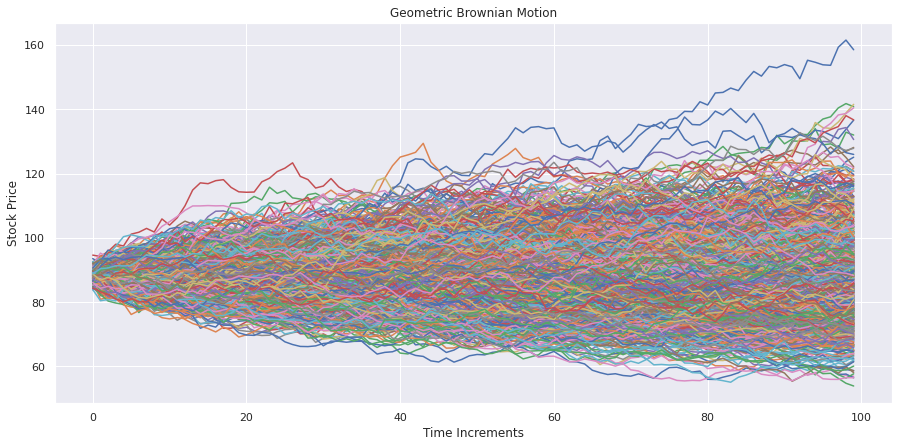

In [ ]:
steps = 100 # time steps
N = 1000 # number of trials
paths = GBM_paths(S,T,r,q,sigma,steps,N)
plt.figure(figsize=(15, 7))
plt.plot(paths);
plt.xlabel("Time Increments")
plt.ylabel("Stock Price")
plt.title("Geometric Brownian Motion")
plt.show()

In [ ]:
payoffs = np.maximum(paths[-1]-K, 0)
option_price = np.mean(payoffs)*np.exp(-r*T)
print(f"Simulated price is {option_price}")

Simulated price is 0.5621296461630204


In [ ]:
call_price_sm = []

for i in range(50,86,5):
    payoffs = np.maximum(paths[-1]-i, 0)
    option_price = np.mean(payoffs)*np.exp(-r*T)
    call_price_sm.append(option_price)

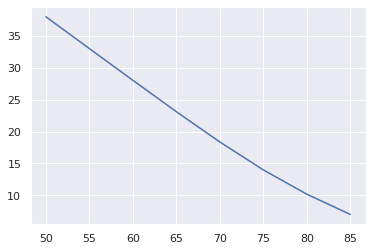

In [ ]:
sns.lineplot(x=[i for i in range(50,86,5)], y=call_price_sm)

##Comparison between the Models

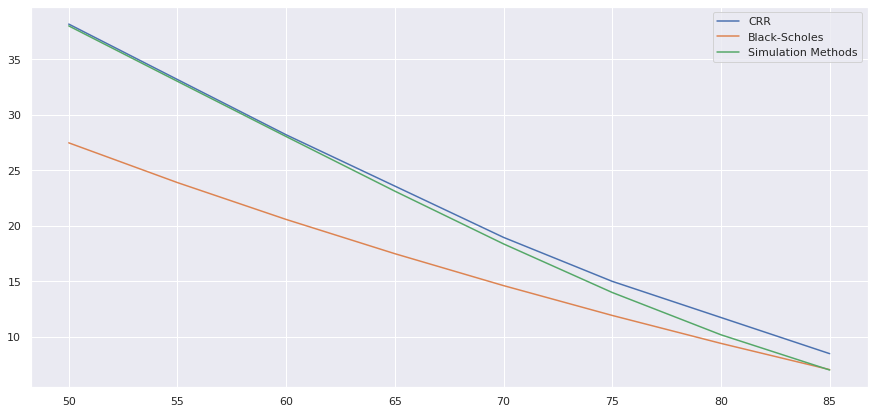

In [ ]:
plt.figure(figsize=(15, 7))
sns.lineplot(x=[i for i in range(50,86,5)], y=call_price, label="CRR")
sns.lineplot(x=[i for i in range(50,86,5)], y=call_price_bs, label="Black-Scholes")
sns.lineplot(x=[i for i in range(50,86,5)], y=call_price_sm, label="Simulation Methods")

The algorithms seems to perform better at higher stock prices, especially black scholes models than the lower ones. 

OptionCRR Price and Simulated price appear to predict better than black scholes price in all the cases.